In [ ]:
import ast
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, RandomSampler
from torchmetrics.classification.accuracy import Accuracy

from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

# Обработка данных

In [ ]:
with open('yc_essential_data.json', 'r') as file:
    data_json = json.load(file)

In [ ]:
data_pd = pd.read_csv('yc_essential_data.csv')

In [ ]:
data_pd.head()

,id,name,slug,former_names,small_logo_thumb_url,website,all_locations,long_description,one_liner,team_size,...,batch,status,industries,regions,stage,app_video_public,demo_day_video_public,app_answers,question_answers,objectID
0,370,Wufoo,wufoo,[],https://bookface-images.s3.amazonaws.com/small...,http://wufoo.com,"Tampa, FL, USA",Wufoo is a web application that helps anybody ...,Online form builder.,11.0,...,W06,Acquired,"[""B2B"", ""Marketing""]","[""United States of America"", ""America / Canada""]",Early,False,False,NaN,False,370
1,369,Project Wedding,project-wedding,[],/company/thumb/missing.png,http://projectwedding.com,"Bethesda, MD, USA","Finding wedding vendors is hard. In 2007, a co...",NaN,2.0,...,W06,Acquired,"[""Consumer"", ""Home and Personal""]","[""United States of America"", ""America / Canada""]",Early,False,False,NaN,False,369
2,367,Clustrix,clustrix,[],https://bookface-images.s3.amazonaws.com/small...,http://clustrix.com,"San Francisco, CA, USA",Clustrix provides the leading scale-out relati...,NaN,51.0,...,W06,Acquired,"[""B2B"", ""Infrastructure""]","[""United States of America"", ""America / Canada""]",Growth,False,False,NaN,False,367
3,366,Inkling,inkling,[],/company/thumb/missing.png,http://inklingmarkets.com,"Chicago, IL, USA","Inkling, based in Chicago, Illinois, offers co...",NaN,11.0,...,W06,Acquired,"[""B2B"", ""Finance and Accounting""]","[""United States of America"", ""America / Canada""]",Early,False,False,NaN,False,366
4,372,Audiobeta,audiobeta,[],/company/thumb/missing.png,http://audiobeta.com,"Somerville, MA, USA",AudioBeta develops web-based applications that...,NaN,0.0,...,W06,Inactive,"[""B2B"", ""Marketing""]","[""United States of America"", ""America / Canada""]",Early,False,False,NaN,False,372


In [ ]:
def has_remote(info):
    if isinstance(info, str):
        return "remote" in info.lower()
    elif isinstance(info, list):
        for subinfo in info:
            if "remote" in subinfo.lower():
                return True
        return False

In [ ]:
data_pd['has_remote'] = (data_pd["all_locations"].apply(has_remote) == True) | (data_pd["regions"].apply(has_remote) == True)

data_pd['has_remote']

0       False
1       False
2       False
3       False
4       False
        ...  
4412    False
4413     True
4414     True
4415     True
4416     True
Name: has_remote, Length: 4417, dtype: bool

In [ ]:
batch_remote = defaultdict(int)
batch_all = defaultdict(int)

REMOTE = "remote"

for startup in data_json:
    batch = startup['batch']
    batch_all[batch] += 1
    batch_remote[batch] += 0
    if REMOTE in startup["all_locations"].lower():
        batch_remote[batch] += 1
    else:
        for region in startup['regions']:
            if REMOTE in region.lower():
                batch_remote[batch] += 1
                break

In [ ]:
print(batch_all.keys())

dict_keys(['W06', 'S08', 'W14', 'S17', 'W09', 'S21', 'IK12', 'W08', 'S22', 'W22', 'S09', 'W17', 'S19', 'S16', 'S23', 'S13', 'S11', 'W19', 'S18', 'Unspecified', 'W23', 'W10', 'W11', 'W20', 'S07', 'S15', 'S12', 'W07', 'S10', 'S20', 'S05', 'W24', 'W12', 'W15', 'W18', 'W13', 'S14', 'S06', 'W16', 'W21'])


In [ ]:
if 'Unspecified' in batch_all.keys():
    del batch_all['Unspecified']
if 'IK12' in batch_all.keys():
    del batch_all['IK12']
if 'Unspecified' in batch_remote.keys():
    del batch_remote['Unspecified']
if 'IK12' in batch_remote.keys():
    del batch_remote['IK12']

In [ ]:
sorted_all_batches = sorted(batch_all.keys(), key=lambda batch: (ord(batch[1]) * 10 + ord(batch[2]), -ord(batch[0])))

In [ ]:
all_batches = batch_all.keys()
fraction_of_remote = [batch_remote[batch] / batch_all[batch] for batch in sorted_all_batches]

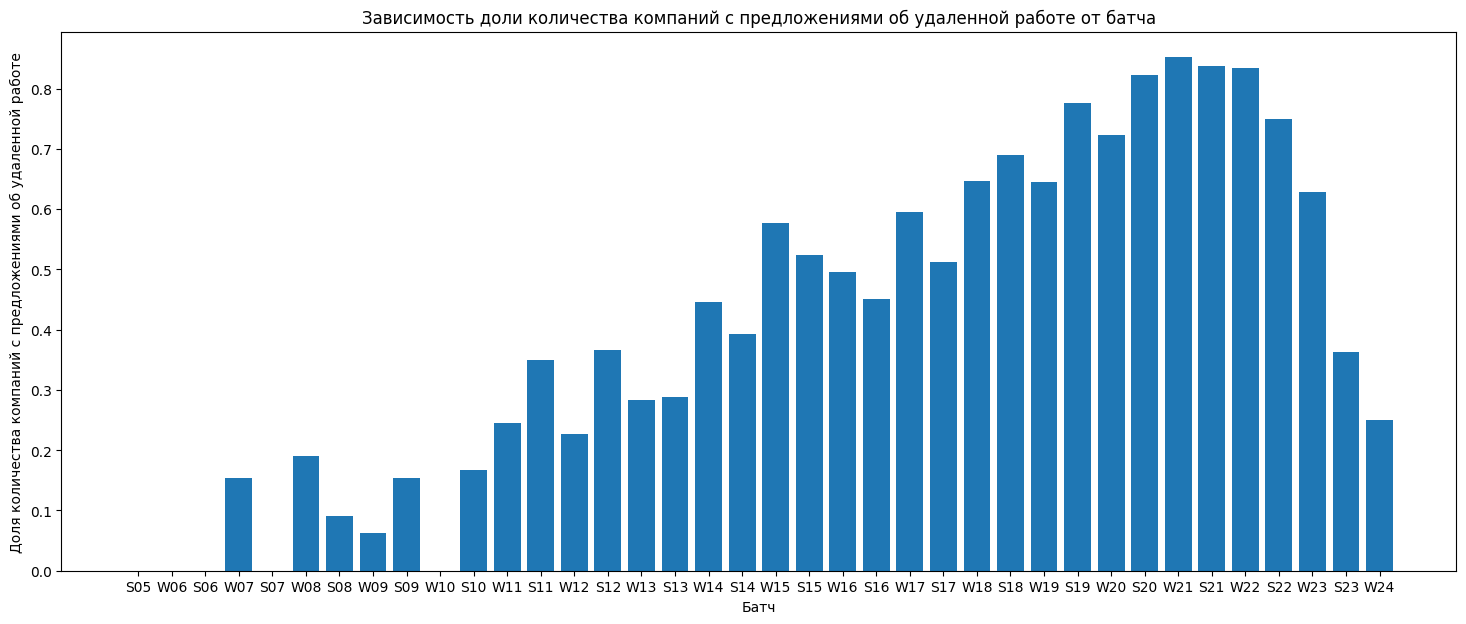

In [ ]:
plt.figure(figsize=(18, 7))

plt.bar(sorted_all_batches, fraction_of_remote)

plt.title('Зависимость доли количества компаний с предложениями об удаленной работе от батча')
plt.xlabel('Батч')
plt.ylabel('Доля количества компаний с предложениями об удаленной работе')


plt.show()


In [ ]:
def get_website_postfix(website: str):
    parsed_url = urlparse(website)
    return parsed_url.netloc.split('.')[-1]


In [ ]:
data_pd_remote = data_pd[(data_pd["all_locations"].apply(has_remote) == True)
                         | (data_pd["regions"].apply(has_remote) == True)]

data_pd_remote = data_pd_remote.dropna(subset=['website'])
data_pd_remote['website_postfix'] = data_pd_remote['website'].apply(get_website_postfix)

In [ ]:
counts_postfix_with_com = data_pd_remote['website_postfix'].value_counts()
print(counts_postfix_with_com)

com       1734
io         209
ai         169
co         147
app         49
          ... 
cafe         1
nyc          1
studio       1
sa           1
team         1
Name: website_postfix, Length: 117, dtype: int64


In [ ]:
data_pd_remote_no_com = data_pd_remote[~data_pd_remote['website_postfix'].isin(['com'])]
counts_postfix = data_pd_remote_no_com['website_postfix'].value_counts()


988


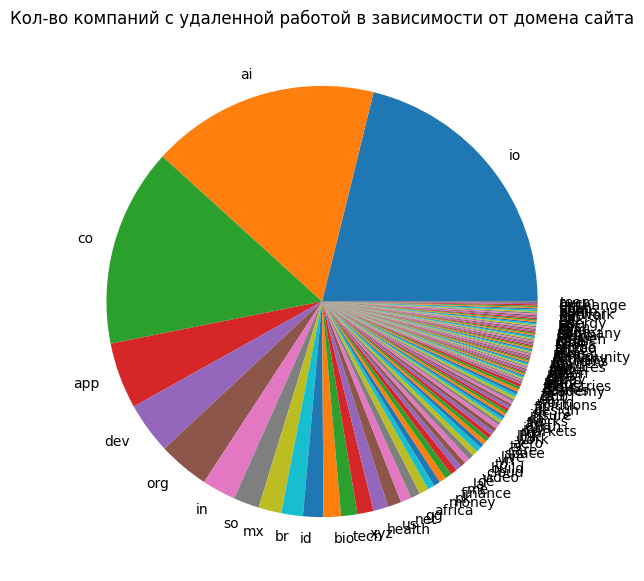

In [ ]:
plt.figure(figsize=(7,7))


sum_counts = np.sum(np.array(counts_postfix.values))
print(sum_counts)
plt.pie(counts_postfix.values, labels=counts_postfix.index)
plt.title('Кол-во компаний с удаленной работой в зависимости от домена сайта')

plt.show()

In [ ]:
data_pd_with_website = data_pd.dropna(subset=['website'])
data_pd_with_website['website_postfix'] = data_pd_with_website['website'].apply(get_website_postfix)
data_pd_postfix = data_pd_with_website['website_postfix'].value_counts()

<ipython-input-87-3bcaceb8a270>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd_with_website['website_postfix'] = data_pd_with_website['website'].apply(get_website_postfix)


In [ ]:
most_popular_postfixes = data_pd_postfix[:10].index

data_pd_with_website = data_pd_with_website[data_pd_with_website['website_postfix'].isin(most_popular_postfixes)]
top_10_most_popular_postfixes_all = data_pd_with_website['website_postfix'].value_counts()

data_pd_remote = data_pd_remote[data_pd_remote['website_postfix'].isin(most_popular_postfixes)]
top_10_most_popular_postfixes_remote = data_pd_remote['website_postfix'].value_counts()

In [ ]:
top_10_fractions_website_postfix = [top_10_most_popular_postfixes_remote[i] / top_10_most_popular_postfixes_all[i]
                                    for i in range(len(top_10_most_popular_postfixes_all.values))]

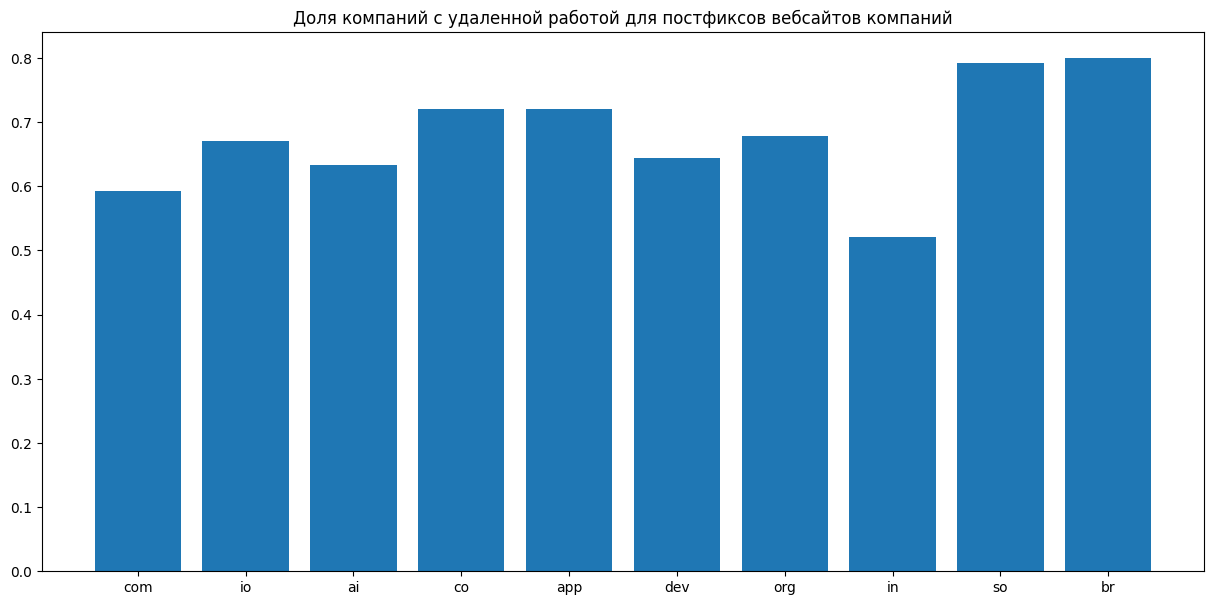

In [ ]:
plt.figure(figsize=(15, 7))

plt.bar(most_popular_postfixes, top_10_fractions_website_postfix)
plt.title("Доля компаний с удаленной работой для постфиксов вебсайтов компаний")

plt.show()

# Анализ удаленной работы в зависимости от индустрии

In [ ]:
industries_num = defaultdict(int)
industries_remote_num = defaultdict(int)


def get_industries(row, industries, industries_remote):
    indusries_list = ast.literal_eval(row['industries'])
    for industry in indusries_list:
        industries[industry] += 1
        if row['has_remote']:
            industries_remote[industry] += 1

data_pd.apply(lambda row, industries=industries_num, industries_remote=industries_remote_num:
              get_industries(row, industries, industries_remote), axis=1)

industries_remote_num

defaultdict(int,
            {'B2B': 1300,
             'Analytics': 69,
             'Consumer': 347,
             'Gaming': 31,
             'Industrials': 116,
             'Automotive': 9,
             'Supply Chain and Logistics': 71,
             'Engineering, Product and Design': 242,
             'Real Estate and Construction': 88,
             'Housing and Real Estate': 55,
             'Consumer Electronics': 12,
             'Fintech': 423,
             'Consumer Finance': 53,
             'Operations': 71,
             'Banking and Exchange': 55,
             'Marketing': 57,
             'Unspecified': 13,
             'Climate': 30,
             'Retail': 66,
             'Credit and Lending': 57,
             'Travel, Leisure and Tourism': 18,
             'Home and Personal': 57,
             'Asset Management': 27,
             'Productivity': 106,
             'Education': 97,
             'Sales': 67,
             'Infrastructure': 125,
             'Finance and Acco

In [ ]:
industries = list()
industries_remote_fraction = list()

for industry in industries_num.keys():
    industries.append(industry)
    industries_remote_fraction.append(industries_remote_num[industry] / industries_num[industry])

In [ ]:
industries_fraction = dict()

for industry in industries_num.keys():
    industries_fraction[industry] = industries_remote_num[industry] / industries_num[industry]

In [ ]:
industries_num_sorted = sorted(industries_num.items(), key=lambda item: item[1], reverse=True)

top_10_industries = industries_num_sorted[:10]
top_10_industries_num_keys, _ = zip(*top_10_industries)

bottom_10_industries = industries_num_sorted[-10:]
bottom_10_industries_num_keys, _ = zip(*bottom_10_industries)

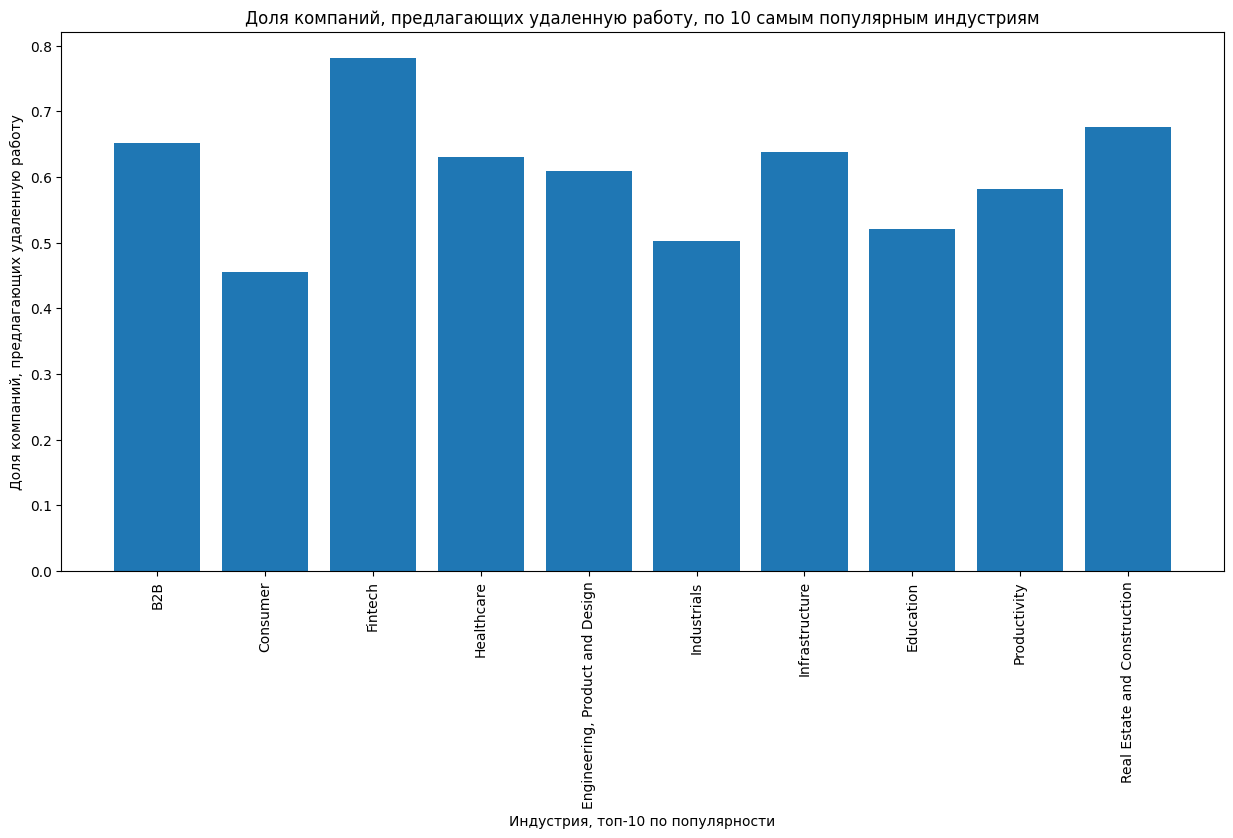

In [ ]:
top_10_industries_fraction_values = [industries_fraction[key] for key in top_10_industries_num_keys]

plt.figure(figsize=(15, 7))

plt.bar(top_10_industries_num_keys, top_10_industries_fraction_values)
plt.title("Доля компаний, предлагающих удаленную работу, по 10 самым популярным индустриям")
plt.xticks(rotation='vertical')
plt.xlabel('Индустрия, топ-10 по популярности')
plt.ylabel('Доля компаний, предлагающих удаленную работу')

plt.show()

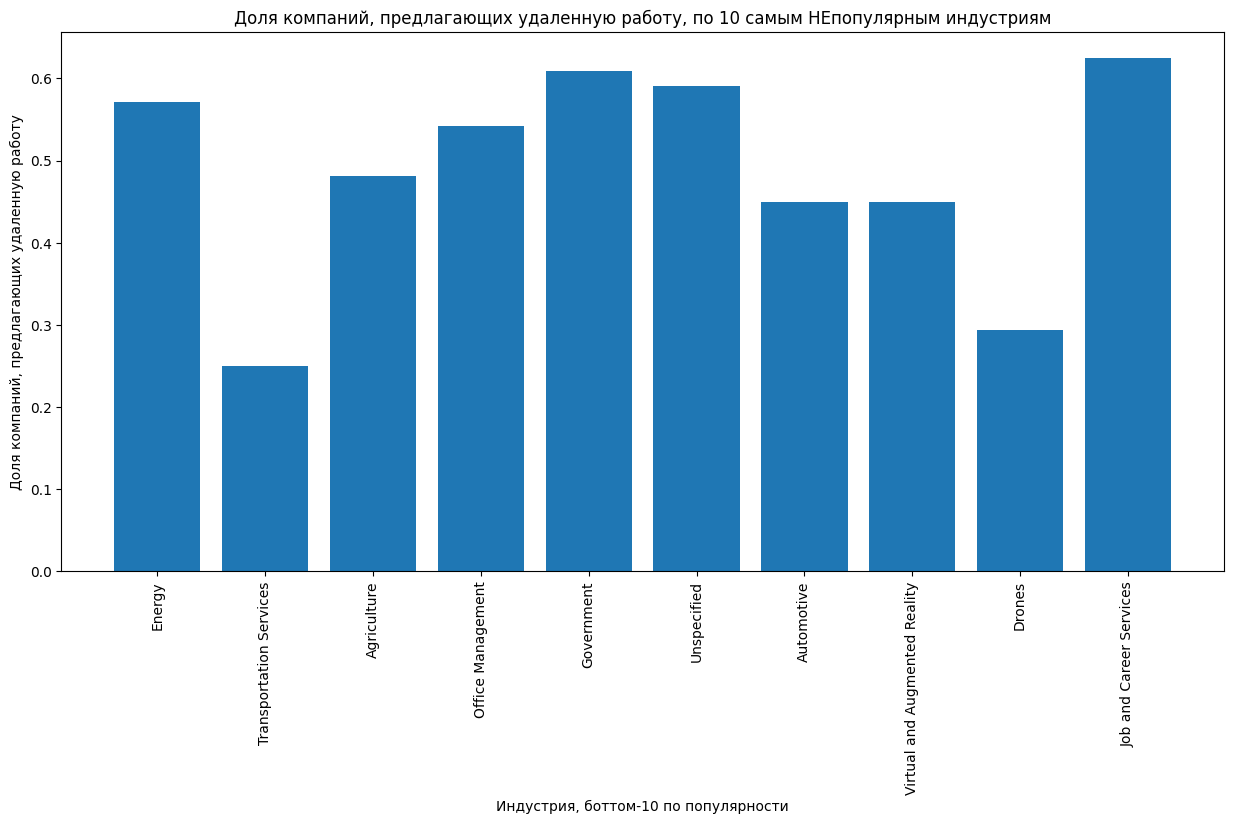

In [ ]:
bottom_10_industries_fraction_values = [industries_fraction[key] for key in bottom_10_industries_num_keys]

plt.figure(figsize=(15, 7))

plt.bar(bottom_10_industries_num_keys, bottom_10_industries_fraction_values)
plt.title("Доля компаний, предлагающих удаленную работу, по 10 самым НЕпопулярным индустриям")
plt.xticks(rotation='vertical')
plt.xlabel('Индустрия, боттом-10 по популярности')
plt.ylabel('Доля компаний, предлагающих удаленную работу')

plt.show()

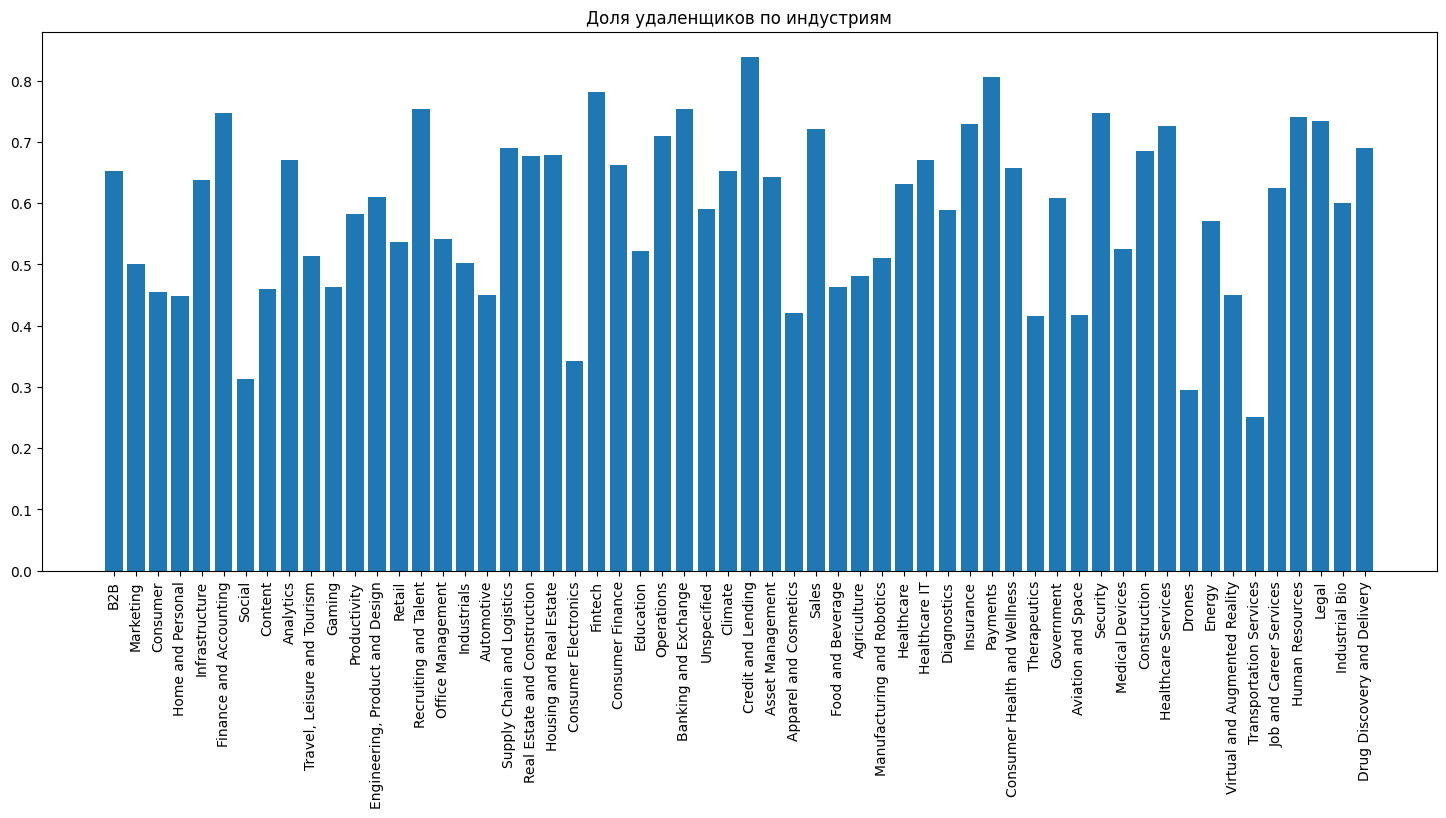

In [ ]:
plt.figure(figsize=(18, 7))

plt.bar(industries, industries_remote_fraction)
plt.title("Доля удаленщиков по индустриям")
plt.xticks(rotation='vertical')

plt.show()

In [ ]:
industries_fraction_sorted = sorted(industries_fraction.items(), key=lambda item: item[1], reverse=True)

print("10 индустрий с самой большой долей компаний с удаленной работой и доля:",
      [industry[0] for industry in industries_fraction_sorted][:10])

10 индустрий с самой большой долей компаний с удаленной работой и доля: ['Credit and Lending', 'Payments', 'Fintech', 'Recruiting and Talent', 'Banking and Exchange', 'Finance and Accounting', 'Security', 'Human Resources', 'Legal', 'Insurance']


In [ ]:
industries_fraction_sorted = sorted(industries_fraction.items(), key=lambda item: item[1])

print("10 индустрий с самой маленькой долей компаний с удаленной работой и доля:",
      [industry[0] for industry in industries_fraction_sorted][:10])

10 индустрий с самой маленькой долей компаний с удаленной работой и доля: ['Transportation Services', 'Drones', 'Social', 'Consumer Electronics', 'Therapeutics', 'Aviation and Space', 'Apparel and Cosmetics', 'Home and Personal', 'Automotive', 'Virtual and Augmented Reality']


In [ ]:
print(data_pd['has_remote'].mean())

0.6182929590219606


# Предсказание Remote по описанию проекта.

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
data_for_prediction = data_pd.reindex(columns=['long_description', 'has_remote'])
data_for_prediction = data_for_prediction.dropna(how="any")

data_for_prediction.head()

,long_description,has_remote
0,Wufoo is a web application that helps anybody ...,False
1,"Finding wedding vendors is hard. In 2007, a co...",False
2,Clustrix provides the leading scale-out relati...,False
3,"Inkling, based in Chicago, Illinois, offers co...",False
4,AudioBeta develops web-based applications that...,False


In [ ]:
def preprocess_text(text):
    text = re.sub("\\\w", ' ', text)
    text = re.sub('[0-9]+', 'NUM', text)
    text = re.sub('[^a-zA-Z]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

In [ ]:
data_for_prediction['long_description'] = data_for_prediction['long_description'].apply(preprocess_text)

In [ ]:
from nltk.corpus import stopwords
from string import punctuation

noise = stopwords.words('english') + list(punctuation)

In [ ]:
df_train = pd.DataFrame(columns=['text', 'label'])
df_val = pd.DataFrame(columns=['text', 'label'])
df_test = pd.DataFrame(columns=['text', 'label'])

df_train['text'], df_test['text'], df_train['label'], df_test['label'] =\
    train_test_split(data_for_prediction['long_description'], data_for_prediction['has_remote'], test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=1)

In [ ]:
df_train

,text,label
3360,Tydo organizes complex data for DTC brands int...,True
4356,Snazzy is a direct to consumer teledentistry p...,True
3714,Anjuna makes hardware grade application and da...,True
1894,Casehopper is AI drafting tool for Immigration...,True
1707,Jumpcut creates captivating online courses Onl...,False
...,...,...
1690,The world s largest omnichannel communications...,False
1068,Fogbender helps BNUMB companies support custom...,True
738,Morf makes it easy to quickly setup and mainta...,True
132,LotusPay is the recurring payments solution fo...,False


In [ ]:
train_texts = [[token.lower() for token in word_tokenize(text) if token.lower() not in noise] for text in df_train["text"].tolist()]
val_texts = [[token.lower() for token in word_tokenize(text) if token.lower() not in noise] for text in df_val["text"].tolist()]
test_texts = [[token.lower() for token in word_tokenize(text) if token.lower() not in noise] for text in df_test["text"].tolist()]

In [ ]:
train_labels = df_train["label"].tolist()
val_labels = df_val["label"].tolist()
test_labels = df_test["label"].tolist()

In [ ]:
class Vocabulary:
    def __init__(self):
        self.word2index = {
            "<pad>": 0,
            "<unk>": 1
        }
        self.index2word = ["<pad>", "<unk>"]

    def build(self, texts, min_count=2):
        words_counter = Counter(token for tokens in texts for token in tokens)
        for word, count in words_counter.most_common():
            if count >= min_count:
                self.word2index[word] = len(self.word2index)
        self.index2word = [word for word, _ in sorted(self.word2index.items(), key=lambda x: x[1])]

    def get_pad(self):
        return self.word2index["<pad>"]

    def get_unk(self):
        return self.word2index["<unk>"]

    @property
    def size(self):
        return len(self.index2word)

    def top(self, n=100):
        return self.index2word[1:n+1]

    def get_index(self, word):
        return self.word2index.get(word, self.get_unk())

    def get_word(self, index):
        return self.index2word[index]

vocabulary = Vocabulary()
vocabulary.build(train_texts)

In [ ]:
class TextDataset(Dataset):
    def __init__(self, tokenized_texts, labels, vocabulary, max_seq_len=55):
        self.samples = []
        assert len(tokenized_texts) != 0
        assert len(tokenized_texts) == len(labels)
        for text, label in zip(tokenized_texts, labels):
            indices = [vocabulary.get_index(word) for word in text][:max_seq_len]
            indices += [vocabulary.get_pad() for _ in range(max_seq_len - len(indices))]
            self.samples.append((torch.LongTensor(indices), torch.LongTensor([label])))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        return self.samples[index]


BATCH_SIZE = 128

train_data = TextDataset(train_texts, train_labels, vocabulary)
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)

val_data = TextDataset(val_texts, val_labels, vocabulary)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

test_data = TextDataset(test_texts, test_labels, vocabulary)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [ ]:
class SimpleModel(LightningModule):
    def __init__(self):
        super().__init__()

        self.loss = nn.BCEWithLogitsLoss()
        self.valid_accuracy = Accuracy(task='binary')
        self.test_accuracy = Accuracy(task='binary')

    def forward(self, inputs, labels):
        raise NotImplementedError("forward not implemented")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return [optimizer]

    def training_step(self, batch, _):
        inputs, labels = batch
        loss, logits = self(inputs, labels)
        return loss

    def validation_step(self, batch, _):
        inputs, labels = batch
        val_loss, logits = self(inputs, labels)
        self.valid_accuracy.update(logits, labels)
        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_acc", self.valid_accuracy)

    def on_validation_epoch_end(self):
        self.log("val_acc_epoch", self.valid_accuracy.compute(), prog_bar=True)

    def test_step(self, batch, _):
        inputs, labels = batch
        test_loss, logits = self(inputs, labels)
        self.test_accuracy.update(logits, labels)
        self.log("test_loss", test_loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy)

    def on_test_epoch_end(self):
        self.log("test_acc_epoch", self.test_accuracy.compute(), prog_bar=True)

In [ ]:
class RnnModel(SimpleModel):
    def __init__(self, vocab_size, embedding_dim=64):
        super().__init__()
        self.embeddings_layer = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_layer = nn.LSTM(embedding_dim, embedding_dim, batch_first=True, bidirectional=True)
        self.dropout_layer = nn.Dropout(0.2)
        self.out_layer = nn.Linear(2 * embedding_dim, 1)

    def forward(self, inputs, labels):
        batch_size = inputs.size(0)
        projections = self.embeddings_layer(inputs)
        # batch_size x seq_len x embedding_dim
        output, (final_hidden_state, final_cell_state) = self.lstm_layer(projections)
        # 2 x batch_size x embedding_dim
        final_hidden_state = final_hidden_state.transpose(0, 1)
        # batch_size x 2 x embedding_dim
        final_hidden_state = final_hidden_state.reshape(batch_size, -1)
        # batch_size x 2*embedding_dim
        hidden = self.dropout_layer(final_hidden_state)
        logits = self.out_layer(hidden)
        loss = self.loss(logits, labels.float())
        return loss, logits

rnn_model = RnnModel(vocabulary.size)
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=1,
    verbose=True,
    mode="min"
)
trainer = Trainer(
    #checkpoint_callback=False,
    accumulate_grad_batches=1,
    max_epochs=10,
    #progress_bar_refresh_rate=10,
    callbacks=[early_stop_callback])
trainer.fit(rnn_model, train_loader, val_loader)
trainer.test(rnn_model, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type              | Params
-------------------------------------------------------
0 | loss             | BCEWithLogitsLoss | 0     
1 | valid_accuracy   | BinaryAccuracy    | 0     
2 | test_accuracy    | BinaryAccuracy    | 0     
3 | embeddings_layer | Embedding         | 513 K 
4 | lstm_layer       | LSTM              | 66.6 K
5 | dropout_layer    | Dropout           | 0     
6 | out_layer        | Linear            | 129   
-------------------------------------------------------
579 K     Trainable params
0         Non-trainable params
579 K     Total params
2.319     Total estimated model params s

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.668


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.663


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.662


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.652


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 1 records. Best score: 0.652. Signaling Trainer to stop.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6421568393707275     │
│      test_acc_epoch       │    0.6421568393707275     │
│         test_loss         │    0.6443109512329102     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6443109512329102,
  'test_acc': 0.6421568393707275,
  'test_acc_epoch': 0.6421568393707275}]

Выглядит так себе. Попробуем что-нибудь попроще.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(min_df=3)
X_train_counts = count_vect.fit_transform(train_texts)
X_train_counts.shape

AttributeError: ignored